# Simple MNIST CNN classification
## By Guillermo Urcera Martín 04/10/18

Let's explore the <a href="http://yann.lecun.com/exdb/mnist/">mnist handwritten digit database</a> and write a CNN capable of classifying the numbers.

We start by importing tensorflow for training, numpy for math and matplotlib to plot data, as well as setting some hyperparameters, such as the learning rate, the L2 regularisation term and the minibatch size, which we'll not optimise here for the sake of simplicity.

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Constants
LEARNING_RATE=1e-3
MAX_EPOCH=600
MINIBATCH_SIZE=256
L2_LAMBDA=1e-3
EPOCHS_PER_LOG=10

We load the dataset from tf.keras.datasets and extract the training and test sets.

In [16]:
# Load data
mnist=tf.keras.datasets.mnist
(images_train, labels_train_1d),(images_test, labels_test_1d)=mnist.load_data()
image_size=len(images_train[0])
train_elements=len(labels_train_1d)
test_elements=len(labels_test_1d)

First, let's take a look at the data, in case it's not as uniform as we expected.

Text(0.5,1,u'Test data')

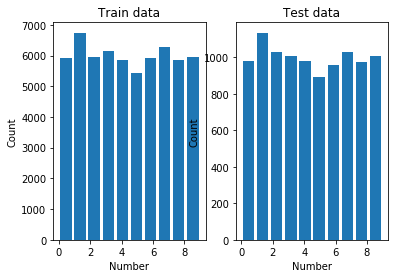

In [17]:
# Take a look at the data
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].hist(labels_train_1d,rwidth=0.8)
axes[0].set_xlabel("Number")
axes[0].set_ylabel("Count")
axes[0].set_title("Train data")

axes[1].hist(labels_test_1d,rwidth=0.8)
axes[1].set_xlabel("Number")
axes[1].set_ylabel("Count")
axes[1].set_title("Test data")

Turns out it's fairly well balanced, let's show an image on screen and take a look at its shape.

Shape: (28, 28)


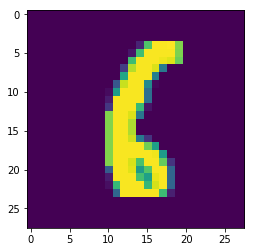

In [18]:
# Let's render a sample image
fig=plt.figure()
index=np.random.randint(train_elements)
image=images_train[index]
plt.imshow(image)
print "Shape:",image.shape

By taking a look at the numbers and formatting, we can see it's a 28*28 pixel grayscale image. Pixel values range from 0 to 255. Let's divide all pixels by 255 to normalize the data a bit and make it easier for a NN to train on it.

In [19]:
# Normalize data
images_train=images_train/255.0
images_test=images_test/255.0

Since we're going to use a softmax output, we'll have to convert our labels from one dimensional numbers to a 10 dimensional bool vector to make the labels match the outputs.

In [20]:
labels_train=np.zeros((train_elements,10))
labels_train[np.arange(train_elements),labels_train_1d]=1

labels_test=np.zeros((test_elements,10))
labels_test[np.arange(test_elements),labels_test_1d]=1

Let's start tensorflow

In [21]:
# Tensorflow init
tf.reset_default_graph()
sess=tf.Session()

We create a simple CNN consisting of 2 convolutional layers, each followed by a max pool layer and two FC layers.
Here's a tensorboard graph:

<img src="https://i.imgur.com/vljlG4l.png">

Notice we add L2 regularisation to all weights except biases.

In [22]:
# Create CNN
input_tensor=tf.placeholder(tf.float32, shape=(None,image_size,image_size,1),name="input_tensor")
label_tensor=tf.placeholder(tf.float32,shape=(None,10),name="label_tensor")

conv1=tf.layers.conv2d(inputs=input_tensor,filters=64,kernel_size=3,padding='valid',activation=tf.nn.relu,name="conv_layer_1")
pool1=tf.layers.max_pooling2d(conv1,2,2,name="max_pool_layer_1")
conv2=tf.layers.conv2d(inputs=pool1,filters=128,kernel_size=3,padding='valid',activation=tf.nn.relu,name="conv_layer_2")
pool2=tf.layers.max_pooling2d(conv2,2,2,name="max_pool_layer_2")
flat=tf.layers.flatten(pool2)
dense1=tf.layers.dense(flat,256,activation=tf.nn.relu,name="dense_layer_1")
output=tf.layers.dense(dense1,10,activation=tf.nn.softmax,name="dense_layer_2")

weights=tf.trainable_variables() 
lossL2=tf.add_n([tf.nn.l2_loss(v) for v in weights if 'bias' not in v.name ])*L2_LAMBDA
cost=tf.reduce_mean(tf.square(output-label_tensor))+lossL2

train=tf.train.AdamOptimizer(LEARNING_RATE).minimize(cost)

In [23]:
# Finalise tensorflow init
init_op=tf.global_variables_initializer()
tf.get_default_graph().finalize()
sess.run(init_op)

Set up arrays for logging learning

In [24]:
training_loss=np.zeros(MAX_EPOCH/EPOCHS_PER_LOG)
test_loss=np.zeros(MAX_EPOCH/EPOCHS_PER_LOG)
test_accuracy=np.zeros(MAX_EPOCH/EPOCHS_PER_LOG)

We reshape the images so that the conv2d layers can see they have 1 channel.

In [25]:
images_train=np.reshape(images_train,(train_elements,image_size,image_size,1))
images_test=np.reshape(images_test,(test_elements,image_size,image_size,1))

To generate the minibatches used in training, we first shuffle the contents of the training images and labels (both in the same order), and then divide the data in chunks, which are our minibatches.

In [26]:
# Generate minibatches
def generate_minibatches(images,labels):
    index=np.random.permutation(len(labels_train))
    x=images_train[index]
    y=labels_train[index]
    minibatch_list=[]
    for i in range(len(y)/MINIBATCH_SIZE):
        minibatch_list.append([x[i*MINIBATCH_SIZE:i*MINIBATCH_SIZE+MINIBATCH_SIZE,:,:],y[i*MINIBATCH_SIZE:i*MINIBATCH_SIZE+MINIBATCH_SIZE]])
    minibatch_list.append([x[i*MINIBATCH_SIZE:len(x),:,:],y[i*MINIBATCH_SIZE:len(y)]])
    return minibatch_list

At last, time to train our model.

In [27]:
acc_test_loss=0
acc_loss=0
log_epoch=0
for epoch in range(MAX_EPOCH):
    minibatch_list=generate_minibatches(images_train,labels_train)
    for minibatch in minibatch_list:
        minibatch_X,minibatch_Y=minibatch
        loss,_=sess.run([cost,train],feed_dict={input_tensor:minibatch_X,label_tensor:minibatch_Y})
        acc_loss+=loss
    if epoch%EPOCHS_PER_LOG==0:
        # Record training loss
        training_loss[log_epoch]=float(acc_loss)/(train_elements*EPOCHS_PER_LOG)
        acc_loss=0
        # Record test loss
        test_loss[log_epoch]=float(sess.run(cost,feed_dict={input_tensor:images_test,label_tensor:labels_test}))/test_elements
        # Record test accuracy
        predicted_value=np.argmax(sess.run(output,feed_dict={input_tensor:images_test}),-1)
        test_accuracy[log_epoch]=1-float(np.count_nonzero(predicted_value-labels_test_1d))/test_elements
        log_epoch+=1
    if epoch%100==0:
        print "Epoch",epoch
print "Done!"

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Done!


Great, now let's plot the learning curves.

Text(0.5,0,u'Epoch')

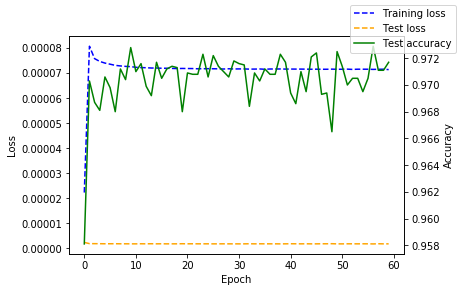

In [29]:
x=np.arange(log_epoch)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(x,training_loss,label='Training loss',color='blue',linestyle='--')
ax1.plot(x,test_loss,label='Test loss',color='orange',linestyle='--')
ax1.set_ylabel("Loss")

ax2=ax1.twinx()
ax2.plot(x,test_accuracy,label='Test accuracy',color='green')
ax2.set_ylabel("Accuracy")
fig.legend()
ax1.set_xlabel('Epoch')

Seems like the net learned to classify the images. We'll ask it to classify an example from the test set for us:

[4]


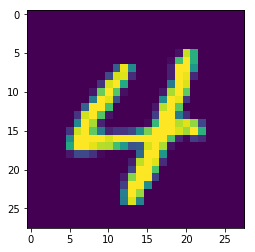

In [30]:
index=np.random.randint(test_elements)


image=images_train[index]

# Reshape for printing
image2=np.reshape(image,(image_size,image_size))
plt.imshow(image2)

answer=np.argmax(sess.run(output,feed_dict={input_tensor:[image]}),-1)
print answer

All done!